# Label Propagation Notebook

## Imports

In [1]:
import hdbscan 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.semi_supervised import LabelPropagation

df = pd.read_csv('../../data/preprocessed_data.csv')
df.drop(inplace=True, columns='Charpy temperature (deg C)')
df.columns

Index(['C concentration (weight%)', 'Si concentration (weight%)',
       'Mn concentration (weight%)', 'S concentration (weight%)',
       'P concentration (weight%)', 'V concentration (weight%)',
       'O concentration (ppm/weight)', 'Ti concentration (ppm/weight)',
       'N concentration (ppm/weight)', 'Al concentration (ppm/weight)',
       'Current (A)', 'Voltage (V)', 'Heat input (kJ/mm)',
       'Interpass temperature (deg C)',
       'Post weld heat treatment temperature (deg C)',
       'Post weld heat treatment time (hours)', 'Yield strength (MPa)',
       'Ultimate tensile strength (MPa)', 'Elongation (%)',
       'Reduction of Area (%)', 'Charpy impact toughness (J)', 'AC',
       'electrode positive', 'Type of weld_GMAA', 'Type of weld_GTAA',
       'Type of weld_MMA', 'Type of weld_NGGMA', 'Type of weld_NGSAW',
       'Type of weld_SA', 'Type of weld_SAA', 'Type of weld_ShMA',
       'Type of weld_TSA'],
      dtype='object')

## Futher data analysis

We want to see if the dataset presents clear clustering behavior so that we can use Label Propagation

In [2]:
df_clustering = df.copy()

# Dropping the test columns
col_test = ['Yield strength (MPa)',
            'Ultimate tensile strength (MPa)', 
            'Elongation (%)',
            'Reduction of Area (%)',
            'Charpy impact toughness (J)']


df_clustering = df_clustering.drop(columns=col_test)
#df_clustering.drop(inplace=True, columns='Charpy temperature (deg C)')
df_clustering.columns

Index(['C concentration (weight%)', 'Si concentration (weight%)',
       'Mn concentration (weight%)', 'S concentration (weight%)',
       'P concentration (weight%)', 'V concentration (weight%)',
       'O concentration (ppm/weight)', 'Ti concentration (ppm/weight)',
       'N concentration (ppm/weight)', 'Al concentration (ppm/weight)',
       'Current (A)', 'Voltage (V)', 'Heat input (kJ/mm)',
       'Interpass temperature (deg C)',
       'Post weld heat treatment temperature (deg C)',
       'Post weld heat treatment time (hours)', 'AC', 'electrode positive',
       'Type of weld_GMAA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA'],
      dtype='object')

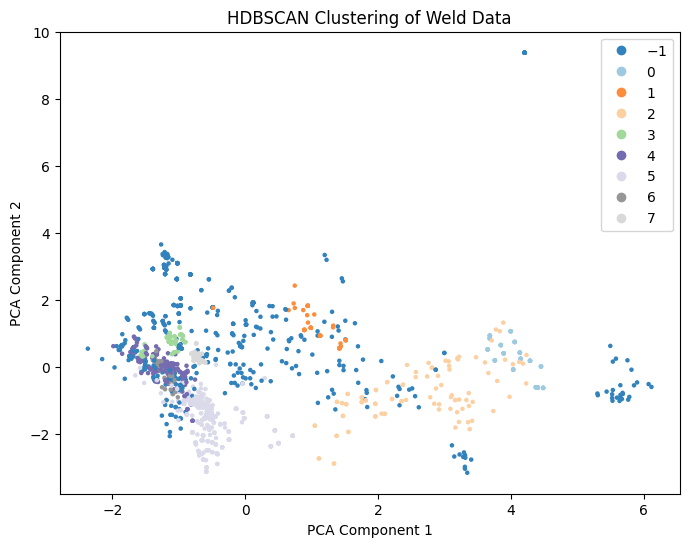

In [3]:
# Clustering the data using hdbscan
hdb = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=1)
clusters = hdb.fit_predict(df_clustering)

pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_clustering)

# Plotting the clusters
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
sc = ax.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters,cmap='tab20c', s=5)
plt.title("HDBSCAN Clustering of Weld Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
ax.legend(*sc.legend_elements())
plt.show()

In [4]:
help(fig.add_subplot)


Help on method add_subplot in module matplotlib.figure:

add_subplot(*args, **kwargs) method of matplotlib.figure.Figure instance
    Add an `~.axes.Axes` to the figure as part of a subplot arrangement.
    
    Call signatures::
    
       add_subplot(nrows, ncols, index, **kwargs)
       add_subplot(pos, **kwargs)
       add_subplot(ax)
       add_subplot()
    
    Parameters
    ----------
    *args : int, (int, int, *index*), or `.SubplotSpec`, default: (1, 1, 1)
        The position of the subplot described by one of
    
        - Three integers (*nrows*, *ncols*, *index*). The subplot will
          take the *index* position on a grid with *nrows* rows and
          *ncols* columns. *index* starts at 1 in the upper left corner
          and increases to the right.  *index* can also be a two-tuple
          specifying the (*first*, *last*) indices (1-based, and including
          *last*) of the subplot, e.g., ``fig.add_subplot(3, 1, (1, 2))``
          makes a subplot that spa

It is clear from the figures above that the dataset shows clustering behavior, which allows us to use the Label Propagation technique.

## Threshold Creation

In [5]:
data = pd.read_table("../data/welddb.data",sep = " ", header=None)
data.replace('N', None, inplace=True)
data.columns = ["C concentration (weight%)","Si concentration (weight%)", "Mn concentration (weight%)","S concentration (weight%)", "P concentration (weight%)", "Ni concentration (weight%)", "Cr concentration (weight%)", "Mo concentration (weight%)", "V concentration (weight%)", "Cu concentration (weight%)", "Co concentration (weight%)", "W concentration (weight%)", "O concentration (ppm/weight)", "Ti concentration (ppm/weight)", "N concentration (ppm/weight)", "Al concentration (ppm/weight)", "B concentration (ppm/weight)", "Nb concentration (ppm/weight)", "Sn concentration (ppm/weight)", "As concentration (ppm/weight)", "Sb concentration (ppm/weight)", "Current (A)", "Voltage (V)", "AC or DC", "Electrode positive or negative", "Heat input (kJ/mm)", "Interpass temperature (deg C)", "Type of weld", "Post weld heat treatment temperature (deg C)", "Post weld heat treatment time (hours)", "Yield strength (MPa)", "Ultimate tensile strength (MPa)", "Elongation (%)", "Reduction of Area (%)", "Charpy temperature (deg C)", "Charpy impact toughness (J)", "Hardness (kg/mm2)", "50 FATT", "Primary ferrite in microstructure (%)", "Ferrite with second phase (%)", "Acicular ferrite (%)", "Martensite(%)", "Ferrite with carbide aggreagate (%)", "Weld ID"]
data = data.replace("<","",regex=True)
data['N concentration (ppm/weight)'] = data['N concentration (ppm/weight)'].str.split("tot").str[0]
data['Hardness (kg/mm2)'] = data['Hardness (kg/mm2)'].str.split("(").str[0]
data['Hardness (kg/mm2)'] = data['Hardness (kg/mm2)'].str.split("H").str[0]
data['Interpass temperature (deg C)'] = data['Interpass temperature (deg C)'].replace('150-200','175')
for i, column in enumerate(data.columns):
    if i not in [23,24,27,43]:
        data[column] = data[column].astype(float)

data.columns = data.columns.map(str)
data = data[col_test]
means = data.mean()
stds = data.std()

In [6]:
thresholds = {
    'Yield strength (MPa)' : {350:[]},
    'Ultimate tensile strength (MPa)' : {500:[]},
    'Elongation (%)': {20:[]},
    'Reduction of Area (%)':{20:[]},
    'Charpy impact toughness (J)':{50:[]}
}

# Normalizing the thresholds
for c in col_test:
    val = list(thresholds[c].keys())[0]
    thresholds[c][val] = (val - means[c]) / stds[c]

In [7]:
from weldlabelpropagation import WeldLabelPropagation
wlp = WeldLabelPropagation(thresholds)

In [8]:
from utils import lp_train_test_split

## Modeling with Label Propagation

In [9]:
 X_train, Y_train, X_test, Y_test = lp_train_test_split(df, col_test, ratio=0.4, seed=666)


In [10]:
X_train.isna()

,C concentration (weight%),Si concentration (weight%),Mn concentration (weight%),S concentration (weight%),P concentration (weight%),V concentration (weight%),O concentration (ppm/weight),Ti concentration (ppm/weight),N concentration (ppm/weight),Al concentration (ppm/weight),Current (A),Voltage (V),Heat input (kJ/mm),Interpass temperature (deg C),Post weld heat treatment temperature (deg C),Post weld heat treatment time (hours)
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1459,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1460,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1461,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [11]:
Y_train

,Yield strength (MPa),Ultimate tensile strength (MPa),Elongation (%),Reduction of Area (%),Charpy impact toughness (J)
0,-1.278195,-1.469907,1.166875,1.002657,NaN
2,-1.051477,-1.108825,1.024036,1.002657,NaN
4,-0.457694,-0.510783,0.656736,0.790400,NaN
5,-0.803168,-0.759027,1.105658,0.801571,0.336142
6,0.038925,-0.093281,0.371059,0.578142,NaN
...,...,...,...,...,...
1458,2.414059,NaN,NaN,NaN,NaN
1459,3.493666,NaN,NaN,NaN,NaN
1460,3.364113,NaN,NaN,NaN,NaN
1461,1.615151,NaN,NaN,NaN,NaN


In [12]:
wlp.fit(X_train, Y_train)
wlp.avg_accuracy(X_test, Y_test)
print(wlp.accuracy_per_column)

Index(['Yield strength (MPa)', 'Ultimate tensile strength (MPa)',
       'Elongation (%)', 'Reduction of Area (%)',
       'Charpy impact toughness (J)'],
      dtype='object')
(1409, 1)
(1409, 1)
(1409, 1)
(1409, 1)
(1409, 1)
(54, 1)
(54, 1)
(54, 1)
(54, 1)
(54, 1)
{'Yield strength (MPa)': 0.6851851851851852, 'Ultimate tensile strength (MPa)': 0.5370370370370371, 'Elongation (%)': 0.7962962962962963, 'Reduction of Area (%)': 0.7592592592592593, 'Charpy impact toughness (J)': 0.8333333333333334}


Since the prediction of labels is most stable for the *Charpy impact toughness*, let's take as a good weld the samples that passed such test (or we could give more importance for this test in this modelizing).

In [21]:
X = pd.concat([X_train, X_test], ignore_index=True)
Y = pd.concat([Y_train, Y_test], ignore_index=True)

wlp.fit(X, Y)
X['y'] = wlp.Y_['Passed ' + col_test[-1]]

Index(['Yield strength (MPa)', 'Ultimate tensile strength (MPa)',
       'Elongation (%)', 'Reduction of Area (%)',
       'Charpy impact toughness (J)'],
      dtype='object')
Index(['Yield strength (MPa)', 'Ultimate tensile strength (MPa)',
       'Elongation (%)', 'Reduction of Area (%)',
       'Charpy impact toughness (J)'],
      dtype='object')
(1463, 1)
(1463, 1)
(1463, 1)
(1463, 1)
(1463, 1)


In [22]:
X.to_csv('../data/target_with_label_propagation.csv', index=False)